In [19]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

In [21]:
def init_nn_params(layer_widths, key):
    """
        Initialize the params and return them as a list of tuples of (weight, bias) pairs
    """
    params = []
    # for each sequential pair of layer widths
    for m, n in zip(layer_widths[:-1], layer_widths[1:]):
        # split key into two new keys
        key, subkey = jax.random.split(key)
        # Xavier initialization
        weight = jax.random.normal(subkey, (m, n)) / np.sqrt(m)
        bias = jnp.zeros(n)
        # append to the list 
        params.append((weight, bias))
    return params

def nn_forward(params, x):
    activations = x
    # hidden layers
    for w, b in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, w) + b)
    # output layer params
    final_w, final_b = params[-1]
    return jnp.dot(activations, final_w) + final_b

def loss_standard(params, t, observed_data, y0):
    """
    Args:
        params: parameters of the neural network
        t (array): array of time points at which to solve the ODE
        observed_data: observed data points (true solution of the ODE at time points t)
        y0: initial state of the system
    """
    def func(y, t):
        return nn_forward(params, y)
    
    # use "odeint" to solve the ODE given the current state of the system
    pred_solution = odeint(func, y0, t)
    return jnp.mean(jnp.abs(pred_solution - observed_data))


# train the neural ODE with ODE sovler approach
def train_nn_standard(params, t, observed_data, y0, lr=1e-3, num_epochs=1000):
    """
        params: Initial parameters of the neural network.
        t: Time points at which to solve the ODE.
        observed_data: Observed data points (true solution of the ODE).
        y0: Initial state of the system.
        lr: Learning rate for the optimizer (default is 0.001).
        num_epochs: Number of training epochs (default is 1000).
    """
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        # loss function requires different params
        loss, grads = jax.value_and_grad(loss_standard)(params, t, observed_data, y0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    for epoch in range(num_epochs):
        loss, params, opt_state = step(params, opt_state)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return params

layer_widths = [2, 100, 100, 2]

def train_model():
    params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
    trained_params_standard = train_nn_standard(params_standard, t, y, y0)

# solve the ODE using the neural network
def neural_ode(params, y0, t):
    def func(y, t):
        return nn_forward(params, y)
    # pass in the trained model as the derivative function
    return odeint(func, y0, t)

In [22]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

In [23]:
def plot_trajectory(t, true_solution, pred_solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(t, true_solution[:, 0], label='True X(t)', color='blue')
    plt.plot(t, true_solution[:, 1], label='True Y(t)', color='orange')
    plt.plot(t, pred_solution[:, 0], '--', label='Predicted X(t)', color='darkblue', alpha=0.6)
    plt.plot(t, pred_solution[:, 1], '--', label='Predicted Y(t)', color='orange', alpha=0.6)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_phase_space(true_solution, pred_solution, title):
    plt.figure(figsize=(5, 5))
    plt.plot(true_solution[:, 0], true_solution[:, 1], label='True Trajectory', color='blue')
    plt.plot(pred_solution[:, 0], pred_solution[:, 1], '--', label='Predicted Trajectory', color='orange')
    plt.xlabel('X(t)')
    plt.ylabel('Y(t)')
    plt.title(title)
    plt.legend(loc='upper right')  # Position the legend in the upper right-hand corner
    plt.show()


In [24]:
#======================= Generate data for Damped Oscillator ======================= (NO NOISE)
n_points = 100
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 1.0
y = odeint(harmonic_oscillator, y0, t, omega_squared)

In [25]:
%%time
# Initialize and train neural network for Damped Oscillator using Standard ODE Solver Approach
params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_standard = train_nn_standard(params_standard, t, y, y0)

pred_solution_standard = neural_ode(trained_params_standard, y0, t)

Epoch 0, Loss: 3.303074359893799
Epoch 100, Loss: 0.6045458316802979
Epoch 200, Loss: 0.5839913487434387
Epoch 300, Loss: 0.5658195614814758
Epoch 400, Loss: 0.6070120930671692
Epoch 500, Loss: 0.5949827432632446
Epoch 600, Loss: 0.5298082828521729
Epoch 700, Loss: 0.5051953196525574
Epoch 800, Loss: 0.05636169761419296
Epoch 900, Loss: 0.050797365605831146
CPU times: user 46.5 s, sys: 379 ms, total: 46.9 s
Wall time: 47 s


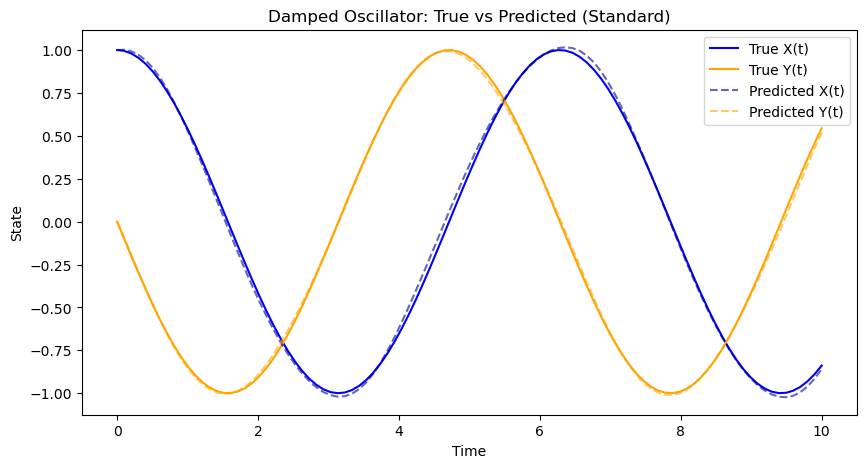

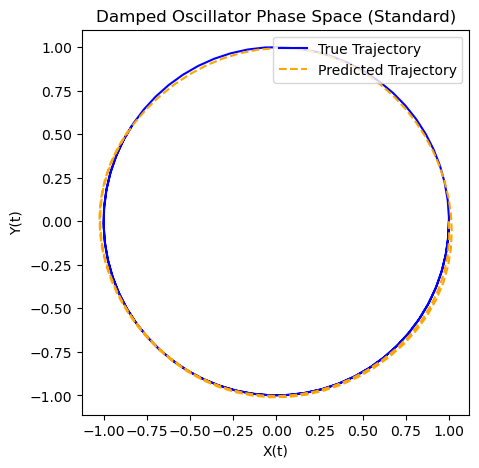

In [26]:
plot_trajectory(t, y, pred_solution_standard, 'Damped Oscillator: True vs Predicted (Standard)')
plot_phase_space(y, pred_solution_standard, 'Damped Oscillator Phase Space (Standard)')

### Define required Neural Network Function

In [27]:
class NeuralODE(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
def create_train_state(rng, layer_widths, learning_rate):
    model = NeuralODE(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones((2,)))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    
def loss_fn(params, apply_fn, t, observed_data, y0):
    def func(y, t):
        return apply_fn({'params': params}, y)
    pred_solution = odeint(func, y0, t)
    return jnp.mean(jnp.abs(pred_solution - observed_data))

@jax.jit
def train_step(state, t, observed_data, y0):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, observed_data, y0, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, observed_data, y0)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

### ODE

In [28]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

### Generate Data

In [42]:
n_points = 200
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 4
y = odeint(harmonic_oscillator, y0, t, omega_squared)

noise = 0.1
y_noisy = y + noise * jax.random.normal(jax.random.PRNGKey(0), y.shape)

In [43]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0)

Epoch 0, Loss: 1.960112452507019
Epoch 100, Loss: 0.7451080679893494
Epoch 200, Loss: 0.8054537773132324
Epoch 300, Loss: 0.8910523653030396
Epoch 400, Loss: 0.9253975749015808
Epoch 500, Loss: 0.9024527072906494
Epoch 600, Loss: 0.923673152923584
Epoch 700, Loss: 0.9133868217468262
Epoch 800, Loss: 0.8280572295188904
Epoch 900, Loss: 0.9205187559127808


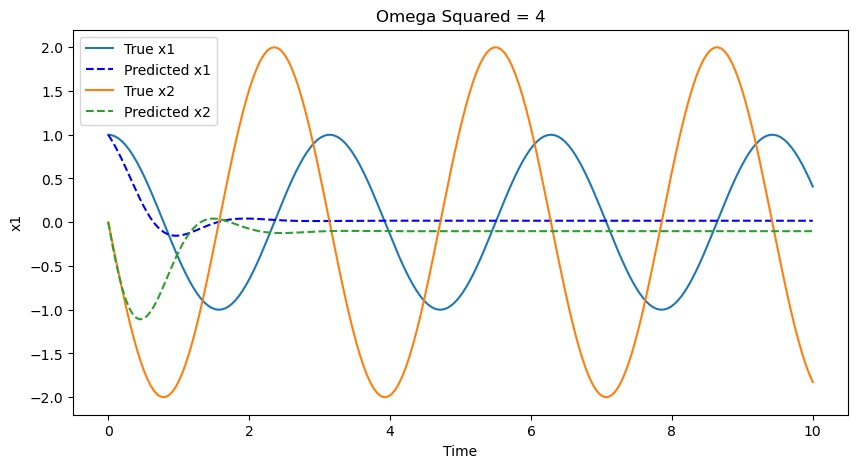

In [44]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


In [35]:
n_points = 200
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 2
y = odeint(harmonic_oscillator, y0, t, omega_squared)

noise = 0.1
y_noisy = y + noise * jax.random.normal(jax.random.PRNGKey(0), y.shape)

In [36]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0)

Epoch 0, Loss: 1.8785876035690308
Epoch 100, Loss: 0.7346981167793274
Epoch 200, Loss: 0.5692057013511658
Epoch 300, Loss: 0.6706007122993469
Epoch 400, Loss: 0.2608402371406555
Epoch 500, Loss: 0.188656747341156
Epoch 600, Loss: 0.11342191696166992
Epoch 700, Loss: 0.1088954508304596
Epoch 800, Loss: 0.11528772860765457
Epoch 900, Loss: 0.09106788784265518


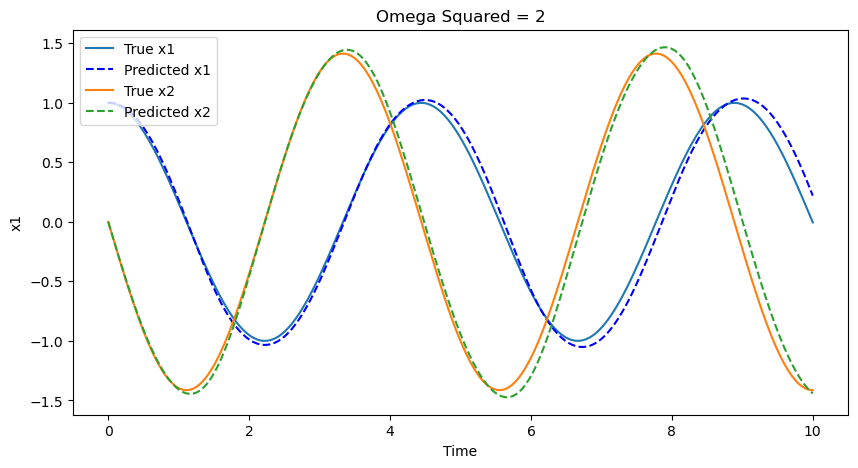

In [37]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()


In [39]:
n_points = 200
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state
# solve the ODE
omega_squared = 3
y = odeint(harmonic_oscillator, y0, t, omega_squared)

noise = 0.1
y_noisy = y + noise * jax.random.normal(jax.random.PRNGKey(0), y.shape)

layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0)

Epoch 0, Loss: 1.9825729131698608
Epoch 100, Loss: 0.8356132507324219
Epoch 200, Loss: 0.7465745210647583
Epoch 300, Loss: 0.6239905953407288
Epoch 400, Loss: 0.8258621692657471
Epoch 500, Loss: 0.4897122085094452
Epoch 600, Loss: 0.8123144507408142
Epoch 700, Loss: 0.26613709330558777
Epoch 800, Loss: 0.115407295525074
Epoch 900, Loss: 0.28811630606651306


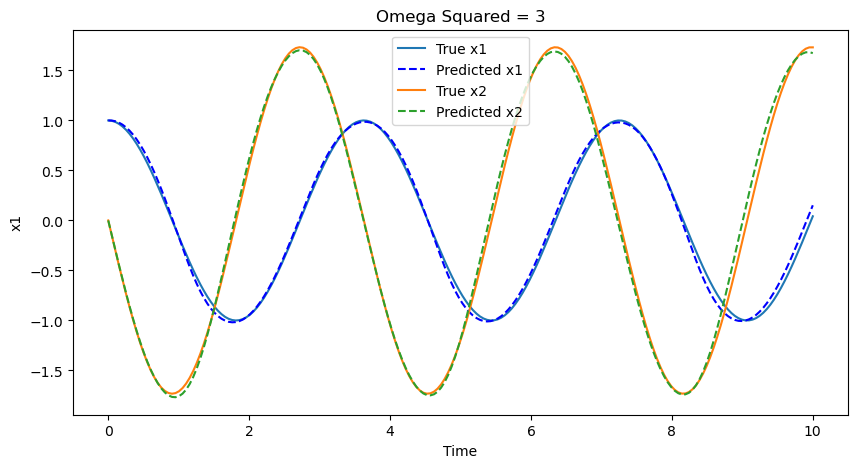

In [40]:
def neural_ode(params, y0, t):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

y_pred = neural_ode(trained_state.params, y0, t)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {omega_squared}')
plt.show()
